## 동시성을 위해 스레드가 필요한 경우에는 ThreadpoolExecutor를 사용하라

- concurrent.futures란 : 비동기 작업(병렬)을 시작하기 위한 높은 수준의 API를 제공하는 표준 라이브러리의 일부입니다
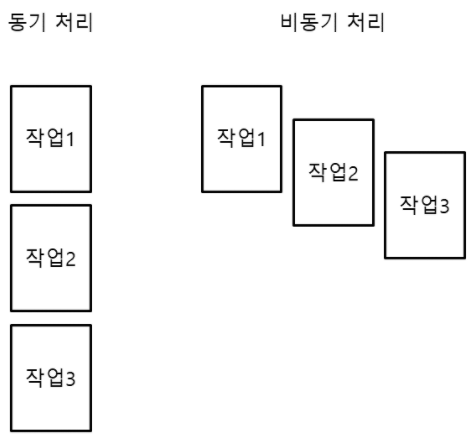
- class concurrent.futures.Executor 란 : 비동기적으로 호출을 실행하는 메서드를 제공하는 추상 클래스입니다. 직접 사용해서는 안 되며, 구체적인 하위 클래스를 통해 사용해야 합니다.
- ThreadPoolExecutor란 : 스레드 풀을 사용하여 호출을 비동기적으로 실행하는 Executor 서브 클래스입니다.

##### 예제는 다른 파일에

- ThreadPoolExecutor는 Thread와 Queue를 사용한 접근 방법들의 장점을 조합해 생명 게임예제의 병렬 I/O문제를 해결한다.
    - Queue란 :  멀티 쓰레딩(threading) 환경에서 사용되며, 내부적으로 라킹(locking)을 지원하여 여러 개의 쓰레드가 동시에 데이터를 추가하거나 삭제할 수 있습니다.

In [4]:
# 기존 리스트의 형태
queue = [4, 5, 6]
queue.insert(0, 3)
queue.insert(0, 2)
print(queue)

queue.pop()

queue.pop()

print(queue)

[2, 3, 4, 5, 6]
[2, 3, 4]


In [5]:
from queue import Queue
#데이터를 추가할 때 Put
# 삭제할땐 get

que = Queue()
que.put(4)
que.put(5)
que.put(6)
que.get()

que.get()

que.get()


6

#### 팬인 팬아웃
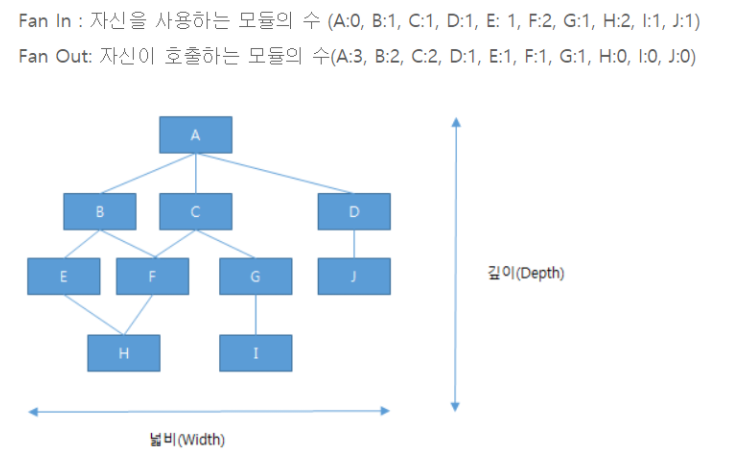

In [6]:
ALIVE = '*'
EMPTY = '-'

class SimulationError(Exception):
    pass
#임의좌표에있는 셀의값을 설정하는 메서드
class Grid:
    def __init__(self, height, width):
        self.height = height
        self.width = width
        self.rows = []
        for _ in range(self.height):
            self.rows.append([EMPTY] * self.width)

    def get(self, y, x):
        return self.rows[y % self.height][x % self.width]

    def set(self, y, x, state):
        self.rows[y % self.height][x % self.width] = state

    def __str__(self):
        output = ''
        for row in self.rows:
            for cell in row:
                output += cell
            output += '\n'
        return output
#쓰레드를 사용할 때는 락을 사용해 데이터 구조에 대해 가정한 내용을 유지하도록 여러 스레드를 조율
#다른 쓰레드에서의 값을 받아올 위험성을 차단
class LockingGrid(Grid):
    def __init__(self, height, width):
        super().__init__(height, width)
        self.lock = Lock()

    def __str__(self):
        with self.lock:
            return super().__str__()

    def get(self, y, x):
        with self.lock:
            return super().get(y, x)

    def set(self, y, x, state):
        with self.lock:
            return super().set(y, x, state)

#셀 주변의 상태를 얻는 방법
# 그리드에 대해 질의를 수행해 살아있는 주변의 셀 수 를 반환하는 도우미 함수        
def count_neighbors(y, x, get):
    n_ = get(y - 1, x + 0) # 북(N)
    ne = get(y - 1, x + 1) # 북동(NE)
    e_ = get(y + 0, x + 1) # 동(E)
    se = get(y + 1, x + 1) # 남동(SE)
    s_ = get(y + 1, x + 0) # 남(S)
    sw = get(y + 1, x - 1) # 남서(SW)
    w_ = get(y + 0, x - 1) # 서(W)
    nw = get(y - 1, x - 1) # 북서(NW)
    neighbor_states = [n_, ne, e_, se, s_, sw, w_, nw]
    count = 0
    for state in neighbor_states:
        if state == ALIVE:
            count += 1
    # 여기서 블러킹 I/O를 수행한다
    #data = my_socket.recv(100)
    return count
#살았으면 살고 죽으면 죽이는 함수
def game_logic(state, neighbors):
    if state == ALIVE:
        if neighbors < 2:
            return EMPTY # 살아 있는 이웃이 너무 적음: 죽음
        elif neighbors > 3:
            return EMPTY # 살아 있는 이웃이 너무 많음: 죽음
    else:
        if neighbors == 3:
            return ALIVE # 다시 생성됨

    # 여기서 블러킹 I/O를 수행한다
    #data = my_socket.recv(100)
    return state
#get과 set을 파라미터로 받는 함수 인터페이스를 사용해 코드의 결합도를 낮춘다.
def step_cell(y, x, get, set):
    state = get(y, x)
    neighbors = count_neighbors(y, x, get)
    next_state = game_logic(state, neighbors)
    set(y, x, next_state)


In [8]:
from concurrent.futures import ThreadPoolExecutor

def simulate_pool(pool, grid):
    next_grid = LockingGrid(grid.height, grid.width)
    futures = []
    for y in range(grid.height):
        for x in range(grid.width):
            args = (y, x, grid.get, next_grid.set)
            future = pool.submit(step_cell, *args)  # 팬아웃
            futures.append(future)

    for future in futures:
        future.result()  # 팬인

    return next_grid

- Grid의 각 셀에 대해 새 Thread 인스턴스를 시작하는 대신, 함수를 실행기에 제출함으로써 팬아웃할 수 있다.
- 실행기는 제출받은 함수를 별도의 스레드에서 수행해준다.
- 나중에 다음과 같이 팬인 하기 위해 모든 작업의 결과를 기대릴 수 있다ㅣ.

- 실행기는 사용할 스레드를 미리 할당한다.
- simulate_pool을 실행할 떄마다 스레드를 시작하는 데 필요한 비용이 들지 않는다.
- 메모리 부족문제는 스레드에서 최대개수 설정이 가능하다.

In [9]:
#시각화
class ColumnPrinter:
    def __init__(self):
        self.columns = []

    def append(self, data):
        self.columns.append(data)

    def __str__(self):
        row_count = 1
        for data in self.columns:
            row_count = max(
                row_count, len(data.splitlines()) + 1)

        rows = [''] * row_count
        for j in range(row_count):
            for i, data in enumerate(self.columns):
                line = data.splitlines()[max(0, j - 1)]
                if j == 0:
                    padding = ' ' * (len(line) // 2)
                    rows[j] += padding + str(i) + padding
                else:
                    rows[j] += line

                if (i + 1) < len(self.columns):
                    rows[j] += ' | '

        return '\n'.join(rows)


In [11]:
from queue import Queue
from threading import Thread
from threading import Lock
import time

from queue import Queue

class ClosableQueue(Queue):
    SENTINEL = object()

    def close(self):
        self.put(self.SENTINEL)

    def __iter__(self):
        while True:
            item = self.get()
            try:
                if item is self.SENTINEL:
                    return   # 스레드를 종료시킨다
                yield item
            finally:
                self.task_done()

in_queue = ClosableQueue()
logic_queue = ClosableQueue()
out_queue = ClosableQueue()

class StoppableWorker(Thread):
    def __init__(self, func, in_queue, out_queue, **kwargs):
        super().__init__(**kwargs)
        self.func = func
        self.in_queue = in_queue
        self.out_queue = out_queue

    def run(self):
        for item in self.in_queue:
            result = self.func(item)
            self.out_queue.put(result)

In [12]:
grid = Grid(5, 9)
grid.set(0, 3, ALIVE)
grid.set(1, 4, ALIVE)
grid.set(2, 2, ALIVE)
grid.set(2, 3, ALIVE)
grid.set(2, 4, ALIVE)

columns = ColumnPrinter()
with ThreadPoolExecutor(max_workers=10) as pool:
    for i in range(5):
        columns.append(str(grid))
        grid = simulate_pool(pool, grid)

print(columns)

    0     |     1     |     2     |     3     |     4    
---*----- | --------- | --------- | --------- | ---------
----*---- | --*-*---- | ----*---- | ---*----- | ----*----
--***---- | ---**---- | --*-*---- | ----**--- | -----*---
--------- | ---*----- | ---**---- | ---**---- | ---***---
--------- | --------- | --------- | --------- | ---------


- ThreadPoolExecutor클래스에서 가장 좋은 점은 submit 메서드가 반환하는 Futur 인스턴스에 대해 result 메서드를 호출하면 스레드를 실행하는 중에 발생한 예외를 자동으로 전파시킨다.

In [13]:
  
from queue import Queue
from threading import Thread
from threading import Lock
import time

from queue import Queue

class ClosableQueue(Queue):
    SENTINEL = object()

    def close(self):
        self.put(self.SENTINEL)

    def __iter__(self):
        while True:
            item = self.get()
            try:
                if item is self.SENTINEL:
                    return   # 스레드를 종료시킨다
                yield item
            finally:
                self.task_done()

in_queue = ClosableQueue()
logic_queue = ClosableQueue()
out_queue = ClosableQueue()

class StoppableWorker(Thread):
    def __init__(self, func, in_queue, out_queue, **kwargs):
        super().__init__(**kwargs)
        self.func = func
        self.in_queue = in_queue
        self.out_queue = out_queue

    def run(self):
        for item in self.in_queue:
            result = self.func(item)
            self.out_queue.put(result)

ALIVE = '*'
EMPTY = '-'

class SimulationError(Exception):
    pass

class Grid:
    def __init__(self, height, width):
        self.height = height
        self.width = width
        self.rows = []
        for _ in range(self.height):
            self.rows.append([EMPTY] * self.width)

    def get(self, y, x):
        return self.rows[y % self.height][x % self.width]

    def set(self, y, x, state):
        self.rows[y % self.height][x % self.width] = state

    def __str__(self):
        output = ''
        for row in self.rows:
            for cell in row:
                output += cell
            output += '\n'
        return output

class LockingGrid(Grid):
    def __init__(self, height, width):
        super().__init__(height, width)
        self.lock = Lock()

    def __str__(self):
        with self.lock:
            return super().__str__()

    def get(self, y, x):
        with self.lock:
            return super().get(y, x)

    def set(self, y, x, state):
        with self.lock:
            return super().set(y, x, state)

def count_neighbors(y, x, get):
    n_ = get(y - 1, x + 0) # 북(N)
    ne = get(y - 1, x + 1) # 북동(NE)
    e_ = get(y + 0, x + 1) # 동(E)
    se = get(y + 1, x + 1) # 남동(SE)
    s_ = get(y + 1, x + 0) # 남(S)
    sw = get(y + 1, x - 1) # 남서(SW)
    w_ = get(y + 0, x - 1) # 서(W)
    nw = get(y - 1, x - 1) # 북서(NW)
    neighbor_states = [n_, ne, e_, se, s_, sw, w_, nw]
    count = 0
    for state in neighbor_states:
        if state == ALIVE:
            count += 1
    # 여기서 블러킹 I/O를 수행한다
    #data = my_socket.recv(100)
    return count

def game_logic(state, neighbors):
    # OSError 발생 에뮬레이션
    raise OSError('I/O 문제 발생')

def step_cell(y, x, get, set):
    state = get(y, x)
    neighbors = count_neighbors(y, x, get)
    next_state = game_logic(state, neighbors)
    set(y, x, next_state)

class ColumnPrinter:
    def __init__(self):
        self.columns = []

    def append(self, data):
        self.columns.append(data)

    def __str__(self):
        row_count = 1
        for data in self.columns:
            row_count = max(
                row_count, len(data.splitlines()) + 1)

        rows = [''] * row_count
        for j in range(row_count):
            for i, data in enumerate(self.columns):
                line = data.splitlines()[max(0, j - 1)]
                if j == 0:
                    padding = ' ' * (len(line) // 2)
                    rows[j] += padding + str(i) + padding
                else:
                    rows[j] += line

                if (i + 1) < len(self.columns):
                    rows[j] += ' | '

        return '\n'.join(rows)


from concurrent.futures import ThreadPoolExecutor

def simulate_pool(pool, grid):
    next_grid = LockingGrid(grid.height, grid.width)
    futures = []
    for y in range(grid.height):
        for x in range(grid.width):
            args = (y, x, grid.get, next_grid.set)
            future = pool.submit(step_cell, *args)  # 팬아웃
            futures.append(future)

    for future in futures:
        future.result()  # 팬인

    return next_grid

with ThreadPoolExecutor(max_workers=10) as pool:
    task = pool.submit(game_logic, ALIVE, 3)
    task.result()

OSError: I/O 문제 발생

- ThreadPoolExecutor가 제한된 수의 I/O 병렬성만 제공한다는 큰 문제점이 남았다.
- Max_workers를 100으로 한다 해도 한번에 1000의 O/I가 필요한 그리드에 10000개 이상의 셀을 넣을 경우 확장이 불가능.
- 그 외 I/O 병렬성을 최대화 할 수 있는 더 나은 방법이 있다..(betterway60)